## **Character level language model - Dinosaurus Land**

Welcome to Dinosaurus Island! In this assignment, you will travel back 65 million years to the age of the dinosaurs. Your mission is crucial: you are responsible for naming newly created dinosaur breeds, brought to life by leading biology researchers. Be careful with your choices; a dissatisfied dinosaur might become uncontrollable!


Fortunately, your deep learning skills will come to the rescue. Your assistant has compiled a comprehensive dataset of existing dinosaur names for you to examine. Using this dataset, you will develop a character-level language model to generate new dinosaur names. Your algorithm will learn various name patterns and create unique names. With any luck, this will help ensure the dinosaurs remain calm and your team stays safe!


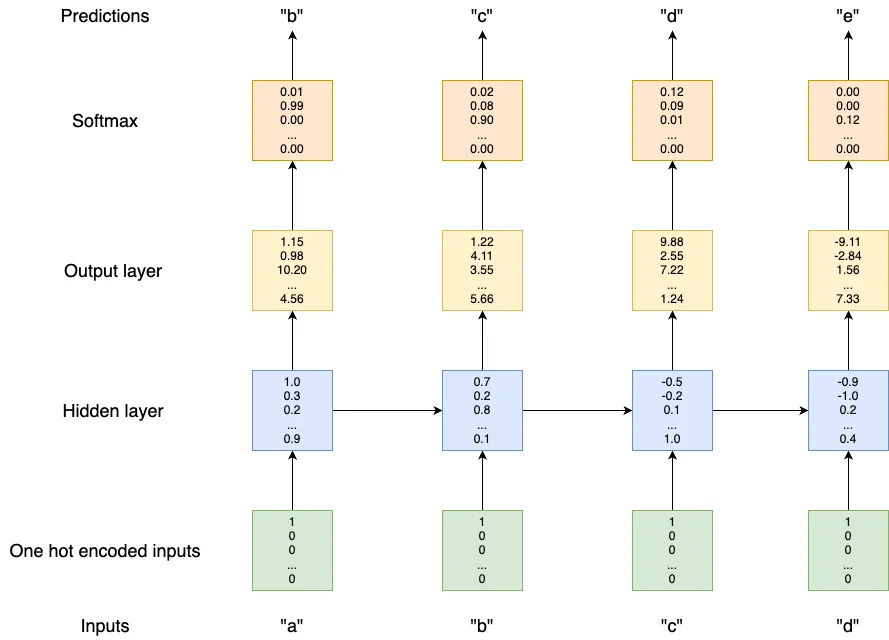

Import Dataset

In [ ]:
import numpy as np
#either mount or upload as suitable
filepath='/content/dinos.txt'

## **1 - Data Generation**


1.1 - Data Prepration

*   Vocabulary formulation
*   Vocabulary Size
*   Example Space

In [ ]:
class DataGenerator:
    """
    A class for generating input and output examples for a character-level language model.
    """

    def __init__(self, path):
        """
        Initializes a DataGenerator object.

        Args:
            path (str): The path to the text file containing the training data.
        """
        self.path = path

        # Read in data from file and convert to lowercase
        with open(path) as f:
            data = f.read().lower()

        # Create list of unique characters in the data
        self.chars = list(set(data))

        # Create dictionaries mapping characters to and from their index in the list of unique characters
        self.char_to_idx = {ch: i for (i, ch) in enumerate(sorted(self.chars))}
        self.idx_to_char = {i: ch for (i, ch) in enumerate(sorted(self.chars))}
        print(self.char_to_idx)
        print()

        # Set the size of the vocabulary (i.e. number of unique characters)
        self.vocab_size = len(self.chars)

        # Read in examples from file and convert to lowercase, removing leading/trailing white space
        with open(path) as f:
            examples = f.readlines()
        self.examples = [x.lower().strip() for x in examples]
        print("No.of Dinos",len(self.examples))
        print()
        print("First 10 Dinos",self.examples[:10])

In [ ]:
data_generator = DataGenerator(filepath)

**Practice Exercise ---- To be filled by Students ----**
1.   Print the total number of chracters and unique chracters in the dataset.
2.   Print the index of chracter 'q' and the word at index = 1.



The characters are a-z (26 characters) plus the "\n" (or newline character), which indicates the end of the dinosaur name. A python dictionary (i.e., a hash table) is created to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Above, `char_to_idx` and `idx_to_char` are the python dictionaries.

1.2 - Generating Training samples from Example Space (input=X,Target=Y)

In [ ]:
def generate_example(self, idx):
    """
    Generates an input/output example for the language model based on the given index.

    Args:
        idx (int): The index of the example to generate.

    Returns:
        A tuple containing the input and output arrays for the example.
    """
    example_chars = self.examples[idx]

    # Convert the characters in the example to their corresponding indices in the list of unique characters
    example_char_idx = [self.char_to_idx[char] for char in example_chars]
    print(example_char_idx)

    # Add newline character as the first character in the input array, and as the last character in the output array
    X = [self.char_to_idx['\n']] + example_char_idx
    Y = example_char_idx + [self.char_to_idx['\n']]

    return np.array(X), np.array(Y)

# Bind the method to the class
DataGenerator.generate_example = generate_example

**Practice Exercise ---- To be filled by Students ----**
- Print the dino representation for the first dino in terms of X and Y
- Check the representation is correct from the index based dictonary created in previous code section

## **2 - Recurrent Neural Networks (RNN)**

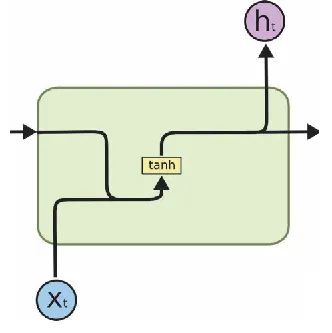

### 2.1 - Overview of the model

Your model will have the following structure:

- Initialize parameters
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameter with the gradient descent update rule.
- Return the learned parameters


At each time-step, the RNN tries to predict what is the next character given the previous characters. The dataset $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set, while $Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is such that at every time-step $t$, we have $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$.

### 2.2 - Let's define the necessary model parameters.

In [ ]:
class RNN:

    def __init__(self, hidden_size, data_generator, sequence_length, learning_rate):
        """
        Initializes an instance of the RNN class.

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the RNN.
        vocab_size : int
            The size of the vocabulary used by the RNN.
        sequence_length : int
            The length of the input sequences fed to the RNN.
        learning_rate : float
            The learning rate used during training.
        """

        # hyper parameters
        self.hidden_size = hidden_size
        self.data_generator = data_generator
        self.vocab_size = self.data_generator.vocab_size

        self.sequence_length = sequence_length
        #based on the max length in the dataset for a dino name
        print("Input Sequence Length", self.sequence_length)
        print()

        self.learning_rate = learning_rate
        self.X = None

        # model parameters

        self.Wax = np.random.uniform(-np.sqrt(1. / self.vocab_size), np.sqrt(1. / self.vocab_size), (hidden_size, self.vocab_size))
        print("Shape of Weight Matrice at Input Wax",self.Wax.shape)
        print()

        self.Waa = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (hidden_size, hidden_size))
        print("Shape of Weight Matrice at (recuuring weights) Hidden State Waa",self.Waa.shape)
        print()

        self.Wya = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (self.vocab_size, hidden_size))
        print("Shape of Weight Matrice at Output Wya",self.Wya.shape)
        print()
        print("Weights at output", self.Wya)

        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((self.vocab_size, 1))

        # Initialize gradients with zero, will accumulate during backpropagation
        self.dWax, self.dWaa, self.dWya = np.zeros_like(self.Wax), np.zeros_like(self.Waa), np.zeros_like(self.Wya)
        self.dba, self.dby = np.zeros_like(self.ba), np.zeros_like(self.by)

        #QUESTION: what is the shape of each gradient matrix corresponding each weigth matrix?

        # parameter update with AdamW, same shape as corresponding weight matrices
        self.mWax = np.zeros_like(self.Wax)
        self.vWax = np.zeros_like(self.Wax)
        self.mWaa = np.zeros_like(self.Waa)
        self.vWaa = np.zeros_like(self.Waa)
        self.mWya = np.zeros_like(self.Wya)
        self.vWya = np.zeros_like(self.Wya)
        self.mba = np.zeros_like(self.ba)
        self.vba = np.zeros_like(self.ba)
        self.mby = np.zeros_like(self.by)
        self.vby = np.zeros_like(self.by)

In [ ]:
rnn= RNN(hidden_size=200,data_generator=data_generator, sequence_length=25, learning_rate=1e-3)

**Side Note:** Initializing weight matrices using a uniform distribution scaled by the square root of a certain factor is a technique used to maintain the variance of the weights, ensuring that they do not become too large or too small. This helps in stabilizing the training process and improving convergence.

### 2.3 - Let's define model methods

    __init__(hidden_size, vocab_size, sequence_length, learning_rate)
        Initializes an instance of the RNN class.

    forward(self, X, a_prev)
     Computes the forward pass of the RNN.

    softmax(self, x)
       Computes the softmax activation function for a given input array. Probability dist output

    loss(self, y_preds, targets)
      Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.
  
    backward(self,x, a, y_preds, targets)
        Implements the backward pass of the RNN.

    adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4)
       Updates the RNN's parameters using the AdamW optimization algorithm.

    train(self, generated_names=5)
       Trains the RNN on a dataset using backpropagation through time (BPTT).

    predict(self, start)
          Generates a sequence of characters using the trained self, starting from the given start sequence.
          The generated sequence may contain a maximum of 50 characters or a newline character.

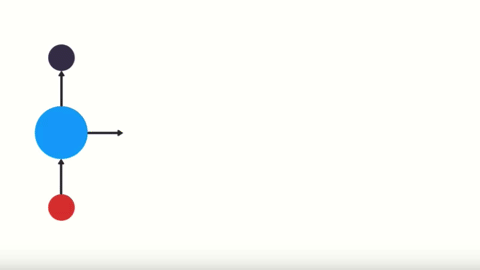

### 2.3.1 - Forward Propagation

During forward propagation, the input sequence is processed through the RNN to generate an output sequence. At each time step, the hidden state and the output are computed using the input, the previous hidden state, and the RNN's parameters.

The equations for the forward propagation in a basic RNN are as follows:

At time step $t$, the input to the RNN is $x_t$, and the hidden state at time step $t-1$ is $a_{t-1}$. The hidden state at time step $t$ is computed as:

**$a_t = \tanh(W_{aa} a_{t-1} + W_{ax} x_t + b_a)$**

where $W_{aa}$ is the weight matrix for the hidden state, $W_{ax}$ is the weight matrix for the input, and $b_a$ is the bias vector for the hidden state.

The output at time step $t$ is computed as:

**$y_t = softmax(W_{ya} a_t + b_y)$**

where $W_{ya}$ is the weight matrix for the output, and $b_y$ is the bias vector for the output.

In [ ]:
def forward(self, X, a_prev):
    """
    Compute the forward pass of the RNN.

    Parameters:
    X (ndarray): Input data of shape (seq_length, vocab_size)
    a_prev (ndarray): Activation of the previous time step of shape (hidden_size, 1)

    Returns:
    x (dict): Dictionary of input data of shape (seq_length, vocab_size, 1), with keys from 0 to seq_length-1
    a (dict): Dictionary of hidden activations for each time step, with keys from 0 to seq_length-1
    y_pred (dict): Dictionary of output probabilities for each time step, with keys from 0 to seq_length-1
    """
    # Initialize dictionaries to store activations and output probabilities.
    x, a, y_pred = {}, {}, {}

    # Store the input data in the class variable for later use in the backward pass.
    self.X = X
    print("Input X for first dino",self.X)
    print("Length of input sequence",len(self.X))

    # Set the initial activation to the previous activation.
    a[-1] = np.copy(a_prev)
    print("Initial activation from hiddens state",a[-1].shape)
    print()

    # iterate over each time step in the input sequence
    for t in range(len(self.X)):
        # get the input at the current time step
        x[t] = np.zeros((self.vocab_size,1))
        if (self.X[t] != None):
            x[t][self.X[t]] = 1
        # compute the hidden activation at the current time step
        print("One hot encoding of X with padded dimension 27x1", x[t])
        print()
        a[t] = np.tanh(np.dot(self.Wax, x[t]) + np.dot(self.Waa, a[t - 1]) + self.ba)
        print("activation shape",a[t].shape)
        # compute the output probabilities at the current time step
        y_pred[t] = self.softmax(np.dot(self.Wya, a[t]) + self.by)

        print("predict", y_pred[t])

      # return the input, hidden activations, and output probabilities at each time step
    return x, a, y_pred

# Bind the method to the class
RNN.forward = forward

In [ ]:
inputs, targets = data_generator.generate_example(0)
a_prev = np.zeros((rnn.hidden_size, 1))
rnn.forward(inputs,a_prev)

**Practice Exercise ---- To be filled by Students ----**
3. Analyze the one hot encoding of the first dino
4. Print the dimension of the matrix passed to the softmax function.



### 2.3.2 - Define Softmax active function
**$$\mathrm{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}
$$**

The softmax function is commonly used as an activation function in neural networks, particularly in the output layer for classification tasks. Given an input array $x$, the softmax function calculates the probability distribution of each element in the array.

In [ ]:
def softmax(self, x):
        """
        Computes the softmax activation function for a given input array.

        Parameters:
            x (ndarray): Input array.

        Returns:
            ndarray: Array of the same shape as `x`, containing the softmax activation values.
        """


# Bind the method to the class
RNN.softmax = softmax

**Practice Exercise ---- To be filled by Students ----**
4.   Code the Softmax function using the equation above.



## 2.3.3 - Cross Entropy Loss

The cross-entropy loss between the predicted probabilities y_pred and the true targets y_true at a single time step $t$ is:

**$$H(y_{true,t}, y_{pred,t}) = -\sum_i y_{true,t,i} \log(y_{pred,t,i})$$**

where $y_{pred,t}$ is the predicted probability distribution at time step $t$, $y_{true,t}$ is the true probability distribution at time step $t$ (i.e., a one-hot encoded vector representing the true target), and $i$ ranges over the vocabulary size.

The total loss is then computed as the sum of the cross-entropy losses over all time steps:

**$$L = \sum_{t=1}^{T} H(y_{true,t}, y_{pred,t})$$**

where $T$ is the sequence length.


In [ ]:
def loss(self, y_preds, targets):
    """
    Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.

    Parameters:
        y_preds (ndarray): Array of shape (sequence_length, vocab_size) containing the predicted probabilities for each time step.
        targets (ndarray): Array of shape (sequence_length, 1) containing the true targets for each time step.

    Returns:
        float: Cross-entropy loss.
    """
    # calculate cross-entropy loss
    return sum(-np.log(y_preds[t][targets[t], 0]) for t in range(len(self.X)))

# Bind the method to the class
RNN.loss = loss

## 2.3.4 - Backward propagation:

The objective of training an RNN is to minimize the loss between the predicted sequence and the ground truth sequence. Backward propagation calculates the gradients of the loss with respect to the RNN's parameters, which are then used to update the parameters using an optimization algorithm such as Adagrad or Adam.

The equations for the backward propagation in a basic RNN are as follows:

At time step $t$, the loss with respect to the output $y_t$ is given by:

**$\frac{\partial L}{\partial y_t} = -\frac{1}{y_{t,i}} \text{ if } i=t_i, \text{ else } 0$**

where $L$ is the loss function, $y_{t,i}$ is the $i$th element of the output at time step $t$, and $t_i$ is the index of the true label at time step $t$.

The loss with respect to the hidden state at time step $t$ is given by:

**$\frac{\partial L}{\partial a_t} = \frac{\partial L}{\partial y_t} W_{ya} + \frac{\partial L}{\partial h_{t+1}} W_{aa}$**

where $\frac{\partial L}{\partial a_{t+1}}$ is the gradient of the loss with respect to the hidden state at the next time step, which is backpropagated through time.

The gradient with respect to tanh is given by:
**$\frac{\partial \tanh(a)} {\partial a}$**

The gradients with respect to the parameters are then computed using the chain rule:

**$\frac{\partial L}{\partial W_{ya}} = \sum_t \frac{\partial L}{\partial y_t} a_t$**

**$\frac{\partial L}{\partial b_y} = \sum_t \frac{\partial L}{\partial y_t}$**

**$\frac{\partial L}{\partial W_{ax}} = \sum_t \frac{\partial L}{\partial a_t} \frac{\partial a_t}{\partial W_{ax}}$**

**$\frac{\partial L}{\partial W_{aa}} = \sum_t \frac{\partial L}{\partial h_t} \frac{\partial h_t}{\partial W_{aa}}$**

**$\frac{\partial L}{\partial b_a} = \sum_t \frac{\partial L}{\partial a_t} \frac{\partial h_t}{\partial b_a}$**

**where $\frac{\partial h_t}{\partial W_{ax}}$, $\frac{\partial a_t}{\partial W_{aa}}$, and $\frac{\partial h_t}{\partial b_a}$ can be computed as:**

**$\frac{\partial a_t}{\partial W_{ax}} = x_t$**

**$\frac{\partial a_t}{\partial W_{aa}} = a_{t-1}$**

**$\frac{\partial a_t}{\partial b_a} = 1$**

These gradients are then used to update the parameters of the RNN using an optimization algorithm such as gradient descent, Adagrad, or Adam.

In [ ]:
def backward(self,x, a, y_preds, targets):
    """
    Implement the backward pass of the RNN.

    Args:
    x -- (dict) of input characters (as one-hot encoding vectors) for each time-step, shape (vocab_size, sequence_length)
    a -- (dict) of hidden state vectors for each time-step, shape (hidden_size, sequence_length)
    y_preds -- (dict) of output probability vectors (after softmax) for each time-step, shape (vocab_size, sequence_length)
    targets -- (list) of integer target characters (indices of characters in the vocabulary) for each time-step, shape (1, sequence_length)

    Returns:
    None

    """
    # Initialize derivative of hidden state for the last time-step
    da_next = np.zeros_like(a[0])

    # Loop through the input sequence backwards
    for t in reversed(range(len(self.X))):
        # Calculate derivative of output probability vector
        dy_preds = np.copy(y_preds[t])
        dy_preds[targets[t]] -= 1

        # Calculate derivative of hidden state
        da = np.dot(self.Waa.T, da_next) + np.dot(self.Wya.T, dy_preds)
        dtanh = (1 - np.power(a[t], 2))
        da_unactivated = dtanh * da

        # Calculate gradients
        self.dba += da_unactivated

        # To-Do

        # Update derivative of hidden state for the next iteration
        da_next = da_unactivated

        # clip gradients to avoid exploding gradients
        for grad in [self.dWax, self.dWaa, self.dWya, self.dba, self.dby]:
            np.clip(grad, -1, 1, out=grad)

# Bind the method to the class
RNN.backward = backward

**Practice Exercise ---- To be filled by Students ----**
5.   Write the code for the computation of derivatives of the weight matrices ('dWax' , 'dWaa' , 'dWya').

## 2.3.5 - AdamW Optimization

In [ ]:
def adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4):
    """
    Updates the RNN's parameters using the AdamW optimization algorithm.
    """
    # AdamW update for Wax
    self.mWax = beta1 * self.mWax + (1 - beta1) * self.dWax
    self.vWax = beta2 * self.vWax + (1 - beta2) * np.square(self.dWax)
    m_hat = self.mWax / (1 - beta1)
    v_hat = self.vWax / (1 - beta2)
    self.Wax -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wax)

    # AdamW update for Waa
    self.mWaa = beta1 * self.mWaa + (1 - beta1) * self.dWaa
    self.vWaa = beta2 * self.vWaa + (1 - beta2) * np.square(self.dWaa)
    m_hat = self.mWaa / (1 - beta1)
    v_hat = self.vWaa / (1 - beta2)
    self.Waa -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Waa)

    # AdamW update for Wya
    self.mWya = beta1 * self.mWya + (1 - beta1) * self.dWya
    self.vWya = beta2 * self.vWya + (1 - beta2) * np.square(self.dWya)
    m_hat = self.mWya / (1 - beta1)
    v_hat = self.vWya / (1 - beta2)
    self.Wya -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wya)

    # AdamW update for ba
    self.mba = beta1 * self.mba + (1 - beta1) * self.dba
    self.vba = beta2 * self.vba + (1 - beta2) * np.square(self.dba)
    m_hat = self.mba / (1 - beta1)
    v_hat = self.vba / (1 - beta2)
    self.ba -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.ba)

    # AdamW update for by
    self.mby = beta1 * self.mby + (1 - beta1) * self.dby
    self.vby = beta2 * self.vby + (1 - beta2) * np.square(self.dby)

# Bind the method to the class
RNN.adamw = adamw

## 2.3.6 - Training

The train method trains the RNN on a dataset using backpropagation through time. The method takes an instance of DataReader containing the training data as input. The method initializes a hidden state vector a_prev at the beginning of each sequence to zero. It then iterates until the smooth loss is less than a threshold value.

During each iteration, it retrieves a batch of inputs and targets from the data reader. The RNN then performs a forward pass on the input sequence and computes the output probabilities. The backward pass is performed using the targets and output probabilities to calculate the gradients of the parameters of the network. The Adagrad algorithm is used to update the weights of the network.

The method then calculates and updates the loss using the updated weights. The previous hidden state is updated for the next batch. The method prints the progress every 500 iterations by generating a sample of text using the sample method and printing the loss.


The train method can be summarized by the following steps:


$1.$ Initialize $a_{prev}$ to zero at the beginning of each sequence.

$2.$ Retrieve a batch of inputs and targets from the data reader.

$3.$ Perform a forward pass on the input sequence and compute the output probabilities.

$4.$ Perform a backward pass using the targets and output probabilities to calculate the gradients of the parameters of the network.

$5.$ Use the Adagrad algorithm to update the weights of the network.

$6.$ Calculate and update the loss using the updated weights.

$7.$ Update the previous hidden state for the next batch.

$8.$ Print progress every 10000 iterations by generating a sample of text using the sample method and printing the loss.

$9.$ Repeat steps $2$-$8$ until the smooth loss is less than the threshold value.

In [ ]:
def train(self, generated_names=5):
    """
    Train the RNN on a dataset using backpropagation through time (BPTT).

    Args:
    - generated_names: an integer indicating how many example names to generate during training.

    Returns:
    - None
    """

    iter_num = 0
    threshold = 5 # stopping criterion for training
    smooth_loss = -np.log(1.0 / self.data_generator.vocab_size) * self.sequence_length  # initialize loss

    while (smooth_loss > threshold):
        a_prev = np.zeros((self.hidden_size, 1))
        idx = iter_num % self.vocab_size
        # get a batch of inputs and targets
        inputs, targets = self.data_generator.generate_example(idx)

        # forward pass
        x, a, y_pred  = self.forward(inputs, a_prev)

        # calculate and update loss
        loss = self.loss(y_pred, targets)

        # backward pass
        self.backward(x, a, y_pred, targets)

        self.adamw()
        smooth_loss = smooth_loss * 0.999 + loss * 0.001

        # update previous hidden state for the next batch
        a_prev = a[len(self.X) - 1]
        # print progress every 500 iterations
        if iter_num % 500 == 0:
            print("\n\niter :%d, loss:%f\n" % (iter_num, smooth_loss))
            for i in range(generated_names):
                sample_idx = self.sample()
                txt = ''.join(self.data_generator.idx_to_char[idx] for idx in sample_idx)
                txt = txt.title()  # capitalize first character
                print ('%s' % (txt, ), end='')
        iter_num += 1

# Bind the method to the class
RNN.train = train

## 2.3.7 - Sampling

In [ ]:
def sample(self):
    """
    Sample a sequence of characters from the RNN.

    Args:
        None

    Returns:
        list: A list of integers representing the generated sequence.
    """
    # initialize input and hidden state
    x = np.zeros((self.vocab_size, 1))
    a_prev = np.zeros((self.hidden_size, 1))

    # create an empty list to store the generated character indices
    indices = []

    # idx is a flag to detect a newline character, initialize it to -1
    idx = -1

    # generate sequence of characters
    counter = 0
    max_chars = 50 # maximum number of characters to generate
    newline_character = self.data_generator.char_to_idx['\n'] # the newline character

    while (idx != newline_character and counter != max_chars):
        # compute the hidden state
        a = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, a_prev) + self.ba)

        # compute the output probabilities
        y = self.softmax(np.dot(self.Wya, a) + self.by)

        # sample the next character from the output probabilities
        idx = np.random.choice(list(range(self.vocab_size)), p=y.ravel())

        # set the input for the next time step
        x = np.zeros((self.vocab_size, 1))
        x[idx] = 1

        # store the sampled character index in the list
        indices.append(idx)

        # update the previous hidden state
        a_prev = a

        # increment the counter
        counter += 1

    # return the list of sampled character indices
    return indices

# Bind the method to the class
RNN.sample = sample

In [ ]:
def predict(self, start):
    """
    Generate a sequence of characters using the trained self, starting from the given start sequence.
    The generated sequence may contain a maximum of 50 characters or a newline character.

    Args:
    - start: a string containing the start sequence

    Returns:
    - txt: a string containing the generated sequence
    """

    # To-Do

# Bind the method to the class
RNN.predict = predict

**Practice Exercise ---- To be filled by Students ----**
6.   Write the code for the 'predict' function.

In [ ]:
# data_generator = DataGenerator(filepath)
# rnn = RNN(hidden_size=200,data_generator=data_generator, sequence_length=25, learning_rate=1e-3)
rnn.train()

**Generate from Predictions**

In [ ]:
rnn.predict("dino")

In [ ]:
rnn.predict("a")